# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn, scipy, zipfile
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16
        }

In [2]:
datafile = 'otomoto_price_prediction_data.csv'
zfile    = 'car_price_prediction_data.csv.zip'

if not os.path.isfile(datafile):
    with zipfile.ZipFile(zfile, 'r') as zip_ref:
        print('Extracting the data file now...')
        zip_ref.extractall()
        print('Done!')

The data we have at hand is the used car sales data, which can be used to predict the car prices based on their specifications, by building a machine learning model. The raw version of data is stored in `df_raw`.

In [3]:
df_raw = pd.read_csv(datafile, low_memory=False)

# Exploring the data 

In [4]:
df_raw

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,audi,a6,2013,153817.0,1984.0,180.0,automatic,petrol,0,0,69900.0
1,skoda,fabia,2004,115000.0,1390.0,75.0,manual,petrol,0,1,8299.0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,automatic,petrol,0,1,54500.0
3,bmw,seria-3,2013,155000.0,1995.0,163.0,automatic,diesel,0,0,62000.0
4,renault,talisman,2017,167000.0,1600.0,130.0,automatic,diesel,0,1,52999.0
...,...,...,...,...,...,...,...,...,...,...,...
206202,mercedes-benz,klasa-b,2018,18000.0,1991.0,211.0,automatic,petrol,0,1,89900.0
206203,honda,jazz,2020,2700.0,1498.0,97.0,automatic,hybrid,0,1,94900.0
206204,mitsubishi,l200,2015,225000.0,2477.0,178.0,manual,diesel,0,1,69900.0
206205,volkswagen,transporter,2006,232000.0,1900.0,105.0,manual,diesel,0,0,29900.0


In [5]:
df_raw.shape

(206207, 11)

The data has 206207 rows (sale instances) and 11 columns (features).

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206207 entries, 0 to 206206
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             206207 non-null  object 
 1   model            206207 non-null  object 
 2   vehicle_year     206207 non-null  int64  
 3   mileage          204853 non-null  float64
 4   engine_capacity  204029 non-null  float64
 5   engine_power     204628 non-null  float64
 6   gearbox          204842 non-null  object 
 7   fuel_type        206207 non-null  object 
 8   damaged          206207 non-null  int64  
 9   is_business      206207 non-null  int64  
 10  target_price     206207 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 17.3+ MB


The information above shows that `make`, `model`, `gearbox`, and `fuel_type` are object datatypes, indicating that they contain strings and therefore can be treated as categorical variables in our analysis. 

`damaged` and `is_business` are Boolian variables, and treated as `int64` datatypes (0 or 1).

In [7]:
df_raw.describe()

,vehicle_year,mileage,engine_capacity,engine_power,damaged,is_business,target_price
count,206207.000000,2.048530e+05,204029.000000,204628.000000,206207.000000,206207.000000,2.062070e+05
mean,2012.313855,6.656787e+05,1865.096922,151.300301,0.038059,0.600038,6.273519e+04
std,6.453940,2.040768e+08,708.559717,76.915073,0.191339,0.489891,8.604596e+04
min,1917.000000,1.000000e+00,400.000000,1.000000,0.000000,0.000000,6.000000e+02
25%,2008.000000,4.500000e+04,1461.000000,105.000000,0.000000,0.000000,1.799900e+04
50%,2013.000000,1.378500e+05,1797.000000,136.000000,0.000000,1.000000,3.590000e+04
75%,2017.000000,1.990000e+05,1997.000000,170.000000,0.000000,1.000000,7.490000e+04
max,2021.000000,9.060612e+10,8400.000000,1500.000000,1.000000,1.000000,5.250000e+06


Few of the descriptive statistical inferences one can derive from above are:

- 75% of cars sold are manufactured before 2017 year.
- On an average, 60% cars were sold by a business.
- On an average, approximately 4% cars sold were damaged.

#### Top 10 car seller brands

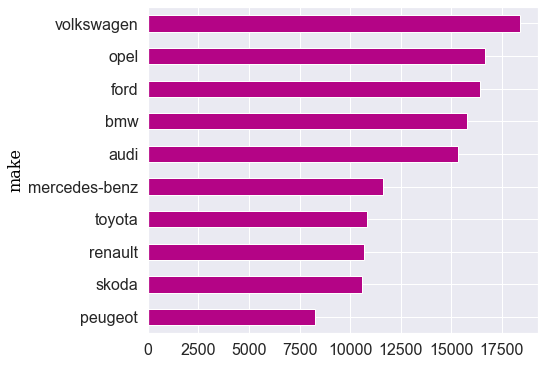

In [8]:
ax = df_raw.groupby(['make']).size().sort_values()[-10:].plot.barh(figsize=(7,6),color='#B40486',fontsize=16)
ax.set_ylabel("make", fontdict=font); plt.show()

#### Top 10 car models sold

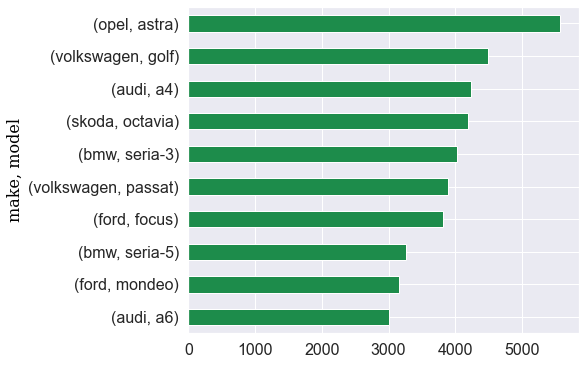

In [9]:
ax= df_raw.groupby(['make','model']).size().sort_values()[-10:].plot.barh(figsize=(7,6),color='#1d8c4b',fontsize=16)
ax.set_ylabel("make, model", fontdict=font); plt.show()

Plots below show the descriptive statistics of rest of the categorical features.

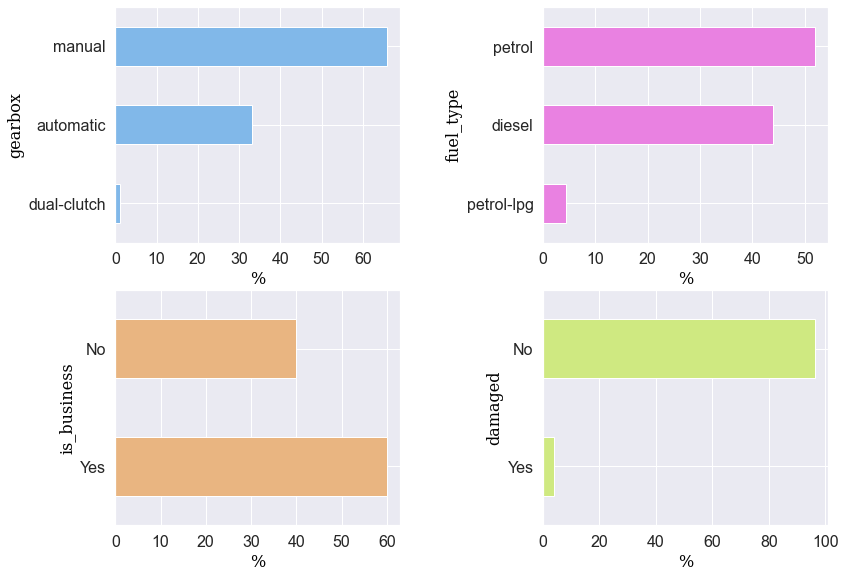

In [10]:
gears = df_raw.groupby('gearbox').size().sort_values()[-3:]  # top 3 gearbox categories sold
gears = gears/sum(gears)*100

fuels = df_raw.groupby('fuel_type').size().sort_values()[-3:]  # top 3 fuel_type categories sold
fuels = fuels/sum(fuels)*100

b = np.mean(df_raw.is_business) # Fraction of cars sold by a business
d = np.mean(df_raw.damaged)     # Fraction of damaged cars 
bseries = pd.Series([b, 1-b], index=['Yes', 'No'])*100  
dseries = pd.Series([d, 1-d], index=['Yes', 'No'])*100
    
fig = plt.figure(figsize = (11, 4))
plt.subplots_adjust(bottom=-0.6, top=1.2, left = 0.0, wspace = 0.5)

ax1  = fig.add_subplot(221)
gears.plot(kind='barh', fontsize=16, color='#81B8E9')
ax1.set_ylabel(f'gearbox', fontdict=font)
ax1.set_xlabel(f'%', fontdict=font)

ax2  = fig.add_subplot(222)
fuels.plot(kind='barh', fontsize=16, color='#E981E1')
ax2.set_ylabel(f'fuel_type', fontdict=font)
ax2.set_xlabel(f'%', fontdict=font)

ax3  = fig.add_subplot(223)
bseries.plot(kind='barh', fontsize=16, color='#E9B581')
ax3.set_ylabel(f'is_business', fontdict=font)
ax3.set_xlabel(f'%', fontdict=font)

ax4  = fig.add_subplot(224)
dseries.plot(kind='barh', fontsize=16, color='#CFE981')
ax4.set_ylabel(f'damaged', fontdict=font)
ax4.set_xlabel(f'%', fontdict=font)

plt.show()

Above plots show that -

- Car gear systems almost fully comprise of `manual`, `automatic` and `dual-clutch` types. Most cars have manual gears, followed by those having automatic gear system. 
- Similarly, car fuels mostly consist of `petrol`, `diesel` or `petrol-lpg`. Most cars run on petrol, followed by those on diesel.
- 60% cars sold are by business and 95% cars are undamaged.

It can also be said that, since the features `gearbox`, `fuel_type` and `damaged` consist of skewed (uneven) sample distribution among their categories, they might have less influence in predicting the target variable (`target_price`) if decision tree models are applied (e.g. Random Forest).

To get a preliminary understanding of the dependent variable `target_price`, we look at its variation with the year of manufacture `vehicle_year` and car `mileage`.

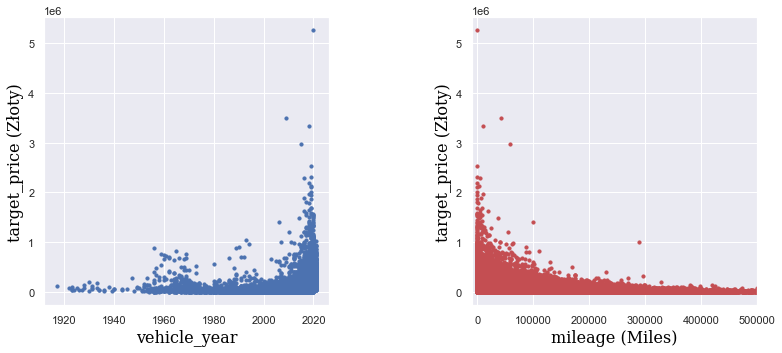

In [11]:
fig = plt.figure(figsize = (11, 4))
plt.subplots_adjust(bottom=0, top=1, left = 0.0, wspace = 0.5)

ax1  = fig.add_subplot(121)
ax1.scatter(df_raw.vehicle_year, df_raw.target_price, s=10)
ax1.set_xlabel('vehicle_year', fontdict=font)
ax1.set_ylabel('target_price (Złoty)', fontdict=font)


ax2  = fig.add_subplot(122)
ax2.scatter(df_raw.mileage, df_raw.target_price, s=10, color='r')
ax2.set_xlim(-1e4, 5e5)
ax2.set_xlabel('mileage (Miles)', fontdict=font)
ax2.set_ylabel('target_price (Złoty)', fontdict=font)

plt.show()

There is an exponential increase in `target_price` with `vehicle_year` and exponential decrease with `mileage`.

The plot below gives a further resolution of `target_price` vs. `vehicle_year` plot above, in terms of the `gearbox` specifications.

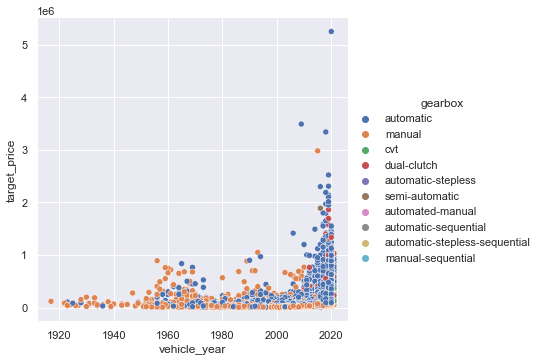

In [12]:
sns.relplot(x = 'vehicle_year', y = 'target_price', hue = 'gearbox', data = df_raw)
plt.show()

It shows that manual gear cars were manufacured in earlier years while automatic ones are manufactured more frequently in recent years.

Plot below shows the histogram of `target_price` and it is seen that most of the cars are sold within the price of 20,000 - 25,000 Złotys.

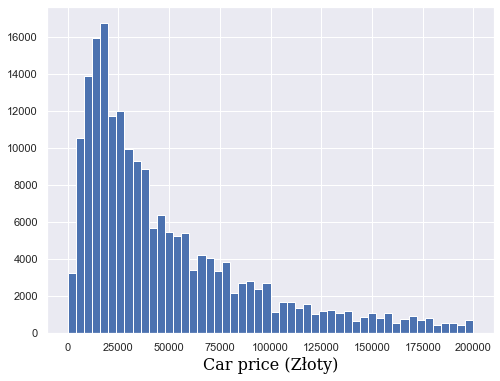

In [13]:
plt.figure(figsize=(8,6))
plt.hist(df_raw.target_price, bins = 50, range = (0, 200000))
plt.xlabel('Car price (Złoty)', fontdict=font)
plt.show()

The relationships of features amongst themselves can be quantified by calculating their pairwise correlations. Below is the calculation of Pearson correlation coefficient.

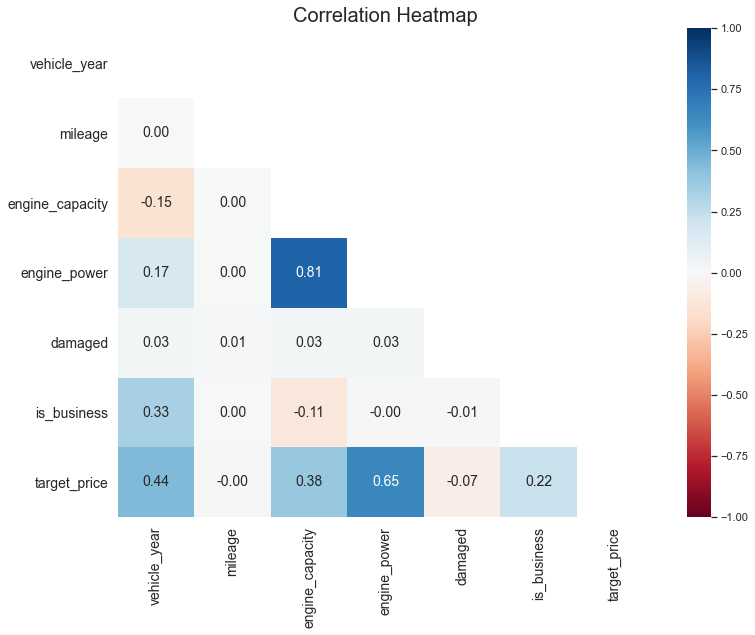

In [14]:
corr = df_raw.corr(method='pearson')

sns.set_style("white")
plt.figure(figsize=(12, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))   # Generate a mask for the upper triangle

s = sns.heatmap(corr, 
                annot = True, 
                mask=mask, 
                fmt = '.2f', 
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1,
                annot_kws={"fontsize":14})

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 14)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 14)
plt.title('Correlation Heatmap', fontsize = 20)
plt.show()

It can be seen that-

- `engine_power` and `engine_capacity` are highly correlated.
- `target_price` positively correlates to `engine_power`, `vehicle_year`, `engine_capacity` `is_business` and negatively correlates to `damaged`.

# Data preprocessing

The data exploration gives us an idea that the functional dependency of `target_price` on the independent variables is fairly non-linear. 
With that in mind, we opt for **Random Forest Regressor** as a candidate to model the data. 

Random Forest is a universal machine learning technique which can model data of mixed category features. It has fewer statistical assumptions compared to other models, needs less feature engineering, and can also work well on large datasets.

It's important to determine the metric to be used for assessing the machine learning model performance. 

Here we use: **RMSLE (Root-Mean-Squared-Log-Error)** between the actual and predicted car prices. 
Therefore we take the log of the prices, so that RMSE will give us what we need.

In [15]:
df_raw.target_price = np.log(df_raw.target_price)

This dataset contains a mix of **continuous** and **categorical** variables.

The categorical variables (`make`, `model`, `gearbox` and `fuel_type`) are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call the function `train_cats` to convert strings to pandas categories. The details of how the functions work are mentioned in their respective docstrings.

In [16]:
def train_cats(df):
    """
    ***Adopted from fastai library (https://github.com/fastai/fastai1) 
    under the Creative Commons Attribution license***
    
    Change any columns of strings in a panda's dataframe to a column of categorical values. 
    This applies the changes inplace.
    
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to categorical values.
    
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for name,col in df.items():
        if is_string_dtype(col): df[name] = col.astype('category').cat.as_ordered()

In [17]:
train_cats(df_raw)

All strings have now been converted to category dtypes. An example of `model` feature is shown below.

In [18]:
df_raw.model.dtype

CategoricalDtype(categories=['1-3', '1-5', '1-6', '100', '1000', '1007', '103', '105',
                  '106', '107',
                  ...
                  'yukon', 'z3', 'z4', 'z4-m', 'zafira', 'zdx', 'zoe', 'zr',
                  'zs', 'zx'],
, ordered=True)

Now we check if there are any missing values in the data. The code below gives the percentage of Null values per column.

In [19]:
np.round(df_raw.isnull().mean().sort_values(ascending=False)*100, 3)

engine_capacity    1.056
engine_power       0.766
gearbox            0.662
mileage            0.657
make               0.000
model              0.000
vehicle_year       0.000
fuel_type          0.000
damaged            0.000
is_business        0.000
target_price       0.000
dtype: float64

The categorical features `make`, `model`, `fuel_type`, `gearbox` are nominal in nature. Their cardinalities are -

In [20]:
df_raw[['make', 'model', 'fuel_type', 'gearbox']].nunique()

make          108
model        1165
fuel_type       7
gearbox        10
dtype: int64

The features `make` and `model` have large cardinality, which makes then unsuitable for one-hot encoding, since it will create a huge number of columns and thus lead to a memory load. 

This is one more reason for using the Random Forest model for this data, since it can work also with the nominal categories with high cardinality, without the need for one-hot encoding.

Now we'll replace categories with their numeric codes, handle missing values, and split the dependent variable into a separate variable. For this purpose, we use the function `proc_df`, adopted from the fastai library, as defined below.

`proc_df` replaces missing values by the median of the respective column and creates a new Boolian column called `feature_name_na` (e.g. `engine_capacity_na`), where the index corresponding to the missing value is assigned True.

In [21]:
# Adopted from fastai library (https://github.com/fastai/fastai1) and modified under the Creative Commons Attribution license

def proc_df(df, y_fld=None, max_n_cat=None):
    
    """ 
    proc_df takes a data frame df, splits off the response variable, and changes the df into an entirely 
    numeric dataframe. For each column of df, na values are replaced by the median value of the column.
    
    Parameters:
    -----------
    df         : The data frame you wish to process.
    y_fld      : The name of the response variable (dependent variable)
    max_n_cat  : The maximum number of categories to break into dummy values, instead of integer codes.
    
    
    Returns:
    --------
    [x, y, nas]:
        x     : x is the transformed version of df. x will not have the response variable 
                and is entirely numeric.
        y     : y is the response variable
        nas   : returns a dictionary of which nas it created, and the associated median.
        
    
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    """
    df = df.copy()
    if y_fld is None: 
        y = None
    else:
        if not is_numeric_dtype(df[y_fld]): 
            df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
    df.drop(y_fld, axis=1, inplace=True)

    na_dict = {}
    na_dict_initial = na_dict.copy()
    for name, col in df.items(): 
        na_dict = fix_missing(df, col, name, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))],
                axis=1, inplace=True)  
    for name, col in df.items(): 
        numericalize(df, col, name, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    res = [df, y, na_dict]
    return res




def fix_missing(df, col, name, na_dict):
    """ 
    Fill missing data in a column of df with the median, and add a {name}_na column which specifies if 
    the data was missing.
    
    Parameters:
    -----------
    df     : The data frame that will be changed.
    col    : The column of data to fix by filling in missing data.
    name   : The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If name is not a key of 
             na_dict the median will fill any missing data. Also if name is not a key of na_dict and there 
             is no missing data in col, then no {name}_na column is not created.
             
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name + '_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict




def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes. 
    
    Parameters:
    -----------
    df       : A pandas dataframe. df[name] will be filled with the integer codes from col.
    col      : The column you wish to change into the categories.
    name     : The column name you wish to insert into df. This column will hold the integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the it to its integer codes. 
               If max_n_cat is None, then col will always be converted.
               
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and (max_n_cat is None or len(col.cat.categories) > max_n_cat):
        df[name] = pd.Categorical(col).codes + 1  # 1 is added to change -1 for NaN to 0.

In [22]:
df, y, _ = proc_df(df_raw, 'target_price')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206207 entries, 0 to 206206
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   make                206207 non-null  int8   
 1   model               206207 non-null  int16  
 2   vehicle_year        206207 non-null  int64  
 3   mileage             206207 non-null  float64
 4   engine_capacity     206207 non-null  float64
 5   engine_power        206207 non-null  float64
 6   gearbox             206207 non-null  int8   
 7   fuel_type           206207 non-null  int8   
 8   damaged             206207 non-null  int64  
 9   is_business         206207 non-null  int64  
 10  mileage_na          206207 non-null  bool   
 11  engine_capacity_na  206207 non-null  bool   
 12  engine_power_na     206207 non-null  bool   
dtypes: bool(3), float64(3), int16(1), int64(3), int8(3)
memory usage: 11.0 MB


The data is now preprocessed and ready to be fed to the model for it to learn. We check how good the model learns in terms of calculating $R^2$.

In [24]:
m = RandomForestRegressor(n_jobs=-1) #n_jobs=-1: parallelizing the computation over all available CPUs
m.fit(df, y)
m.score(df, y)

0.9923938652387393

The model learns the data very well. But is the data getting overfitted? We check it by seeing how good are the model predictions for the unseen data. For this purpose, we split the data into separate training & validation data sets. The validation dataset size is 50,000 rows and rest is the training dataset.

In [25]:
def split_vals(a,n): 
    '''Split the dataframe 'a' into training and validation datasets '''
    return a[:n].copy(), a[n:].copy()


n_valid = 50000   # Size of validation dataset
n_trn = len(df) - n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

print(f'X_train.shape: {X_train.shape}; y_train.shape: {y_train.shape}; X_valid.shape: {X_valid.shape}')

X_train.shape: (156207, 13); y_train.shape: (156207,); X_valid.shape: (50000, 13)


# Model performance

In [26]:
def rmse(x,y): 
    '''Root-mean-squared error; x = actual value; y = predicted value'''
    return np.sqrt(((x-y)**2).mean())

def print_score(m, x_train, x_valid, y_train, y_valid):
    '''Function that outputs the metric for model performance'''
    res = {'training rmse'   : rmse(m.predict(x_train), y_train),
           'validation rmse' : rmse(m.predict(x_valid), y_valid),
           'training score'  : m.score(x_train, y_train),
           'validation score': m.score(x_valid, y_valid)}
    if hasattr(m, 'oob_score_'): res['oob score'] = m.oob_score_
    return pd.Series(res)

In [27]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m, X_train, X_valid, y_train, y_valid)

CPU times: user 1min 41s, sys: 292 ms, total: 1min 42s
Wall time: 26.3 s


training rmse       0.090811
validation rmse     0.231821
training score      0.992218
validation score    0.948274
dtype: float64

So the validation $R^2 \approx 0.95$, which is quite good.

## Effect of the number of trees on model performance

In the previous model, among the ensemble of trees (estimators), we extract the prediction of each individual tree for the validation dataset.

In [28]:
preds = np.stack([tree.predict(X_valid) for tree in m.estimators_])
preds.shape

(100, 50000)

We now see how increasing the trees gradually changes $R^2$.

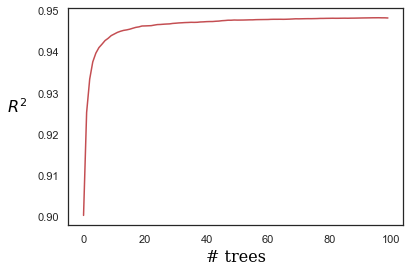

In [29]:
plt.figure(figsize=(6,4))
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1,:], axis=0)) for i in range(len(m.estimators_))], 'r-')
plt.xlabel('# trees', fontdict=font)
plt.ylabel(r'$R^2$', fontdict=font, rotation=0, labelpad=20)
plt.show()

The shape of this curve suggests that adding more trees isn't going to help us much, since the score more or less reaches a plateau at high number of trees. For example, setting the number of trees to 40 is not going to give a drastically different score than 100 trees. We therefore set `n_estimators = 40` for further analysis, in order to reduce computational costs.

In [30]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m, X_train, X_valid, y_train, y_valid)

CPU times: user 40.8 s, sys: 180 ms, total: 41 s
Wall time: 10.7 s


training rmse       0.093830
validation rmse     0.232942
training score      0.991692
validation score    0.947772
dtype: float64

## Reducing overfitting

### Generalizing the model

One of the ways to reduce overfitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [31]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m, X_train, X_valid, y_train, y_valid)

CPU times: user 35.4 s, sys: 116 ms, total: 35.5 s
Wall time: 9.36 s


training rmse       0.152252
validation rmse     0.231764
training score      0.978125
validation score    0.948299
dtype: float64

### Reducing the correlation among trees

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

In [32]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m, X_train, X_valid, y_train, y_valid)

CPU times: user 18.7 s, sys: 44 ms, total: 18.7 s
Wall time: 4.94 s


training rmse       0.163436
validation rmse     0.228999
training score      0.974793
validation score    0.949525
dtype: float64

## Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [33]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [34]:
fi = rf_feat_importance(m, df); fi

,cols,imp
2,vehicle_year,0.498405
5,engine_power,0.178162
3,mileage,0.138562
6,gearbox,0.069291
4,engine_capacity,0.051249
0,make,0.016941
1,model,0.016161
8,damaged,0.015980
9,is_business,0.008187
7,fuel_type,0.004866


In [35]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(9,7), fontsize=16, legend=False)

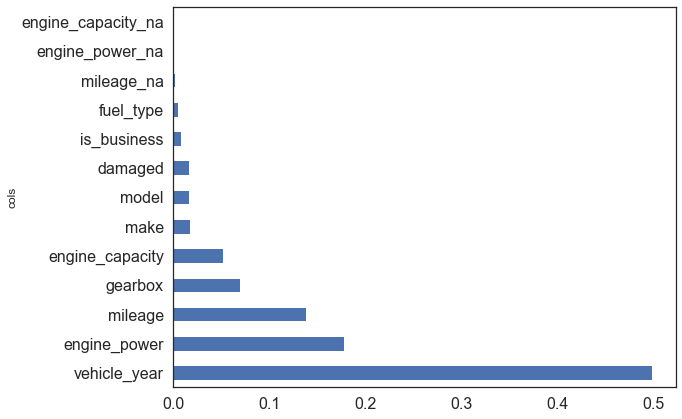

In [36]:
plot_fi(fi); plt.show()

The plot above shows the importance of each feature in determining the `target_price`. It seems that the feature `vehicle_year` is the most decisive one followed by `engine_power`, `mileage` and so on.

However, one needs to be careful in inpterpreting this information, since the important features could just be correlated to other features.

We now attempt to simplify our feature set by deleting the non-influential features, based on certain criterion.

In [37]:
to_keep = fi[fi.imp > 0.005].cols; to_keep

2       vehicle_year
5       engine_power
3            mileage
6            gearbox
4    engine_capacity
0               make
1              model
8            damaged
9        is_business
Name: cols, dtype: object

We now create a new dataframe `df_keep` which contains important (`to_keep`) features, and split the data into training and testing set to feed to Random Forest model.

In [38]:
df_keep = df[to_keep].copy()
X_keep_train, X_keep_valid = split_vals(df_keep, n_trn)

In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_keep_train, y_train)
print_score(m, X_keep_train, X_keep_valid, y_train, y_valid)

training rmse       0.164761
validation rmse     0.230110
training score      0.974383
validation score    0.949034
dtype: float64

We see that $R^2$ (validation score) is almost unchanged.

## Final model

In [40]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1)
m.fit(X_keep_train, y_train)
print_score(m, X_keep_train, X_keep_valid, y_train, y_valid)

training rmse       0.089317
validation rmse     0.227910
training score      0.992472
validation score    0.950004
dtype: float64

# Partial dependence

Now we have the opportunity to really understand the data better by taking advantage of the learned model.
When using black box machine learning algorithms like random forest and boosting, it is hard to understand the predictor-model outcome relationship. 

Although we can know which feature is significantly influencing the outcome based on the feature importance calculation, we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. Partial dependence plots are powerful tools to help understanding the complex relations between predictors and model prediction.

In [41]:
from pdpbox import pdp    # Python partial dependence plot toolbox
from plotnine import *    # Grammar of graphics for python

In [42]:
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    
    Returns:
    --------
    return value: A random sample of n rows of df.
    
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [43]:
x_all = get_sample(df_raw, 5000)

We now look at the relationship between `engine_capacity` and `target_price`.

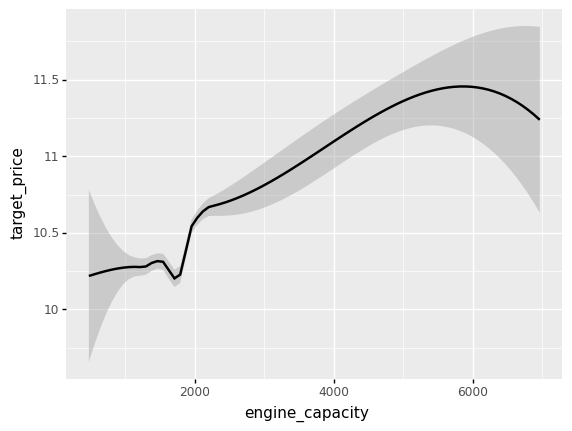

<ggplot: (8773713771001)>

In [44]:
ggplot(x_all, aes('engine_capacity', 'target_price')) + stat_smooth(se=True, method='loess')

We see that the `target_price` does not increase monotonically with `engine_capacity`. It is expected that `target_price` will increase with increasing `engine_capacity`.

However, there are a lot of underlying multicollinearity effects that can drive such relationships. Therefore, univariate plots like this can be misleading and should be interpreted with caution.

Partial dependence plots allow us to find the true relationships, all other features being equal.
As an example, if the `target_price` at `engine_capacity` = 2000 cc is `x`, what will be the `target_price` at `engine_capacity` = 4000 cc, given that all other feature specifications at the two cases are identical?
Partial dependence plots help us find an answer to such questions.

For that, we take a random sample of 500 rows from the data, and plot partial dependence of the desired feature on `target_price`, based on the learned model.

In [45]:
x = get_sample(X_keep_train, 500)

In [46]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model=m, dataset=x, model_features=x.columns, feature=feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

We check how `engine_capacity` influences `target_price`.

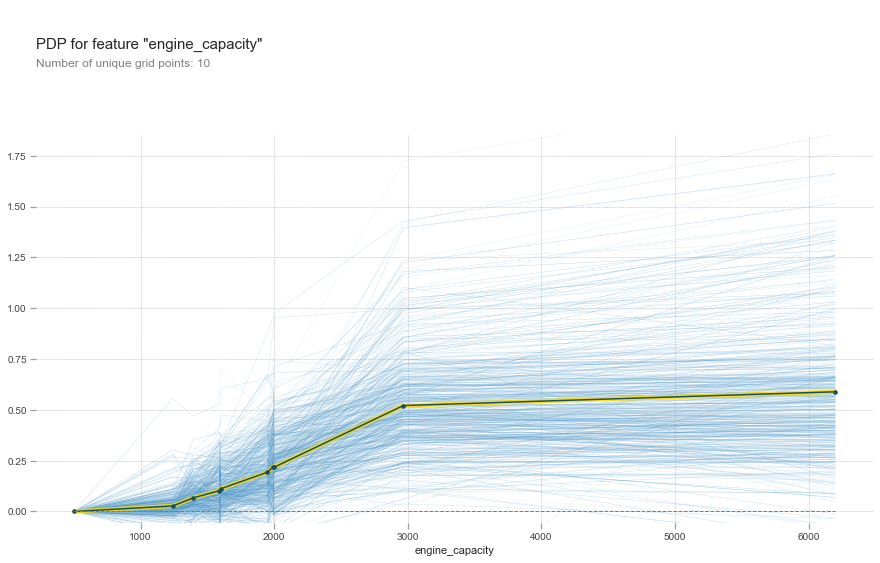

In [47]:
plot_pdp('engine_capacity'); plt.show()

The light blue lines in the above plot show all 500 predictions vs. `engine_capacity`. 

The yellow line is the average of all 500 lines and shows the true relationship between `engine_capacity` and `target_price`. As expected, `target_price` increases monotonically with `engine_capacity`.

More information on these plots can be accessed at https://pdpbox.readthedocs.io/en/latest/.

We now perform the same analysis for `vehicle_year` and `target_price` relationship.

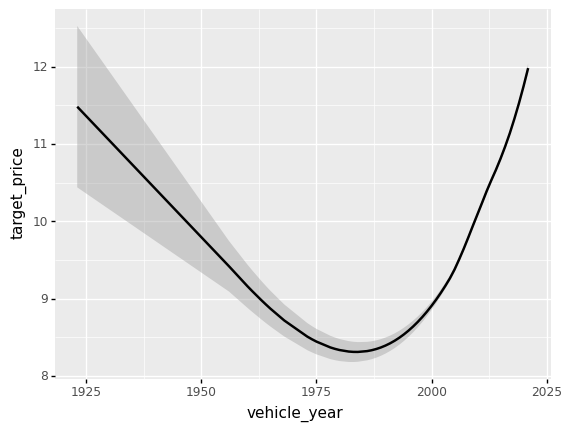

<ggplot: (8773682612285)>

In [48]:
ggplot(x_all, aes('vehicle_year', 'target_price')) + stat_smooth(se=True, method='loess')

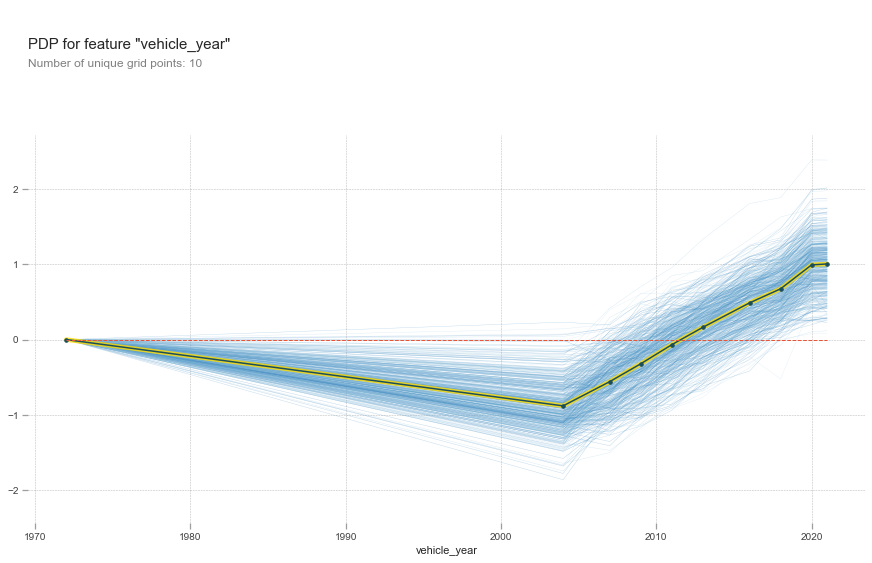

In [49]:
plot_pdp('vehicle_year'); plt.show()

It shows that `target_price` dips for a bit till year 2005 and resurges back again with year.

The following figure shows the PDP interaction plot, i.e., how `engine_capacity` and `vehicle_year` *together* impact `target_price`.

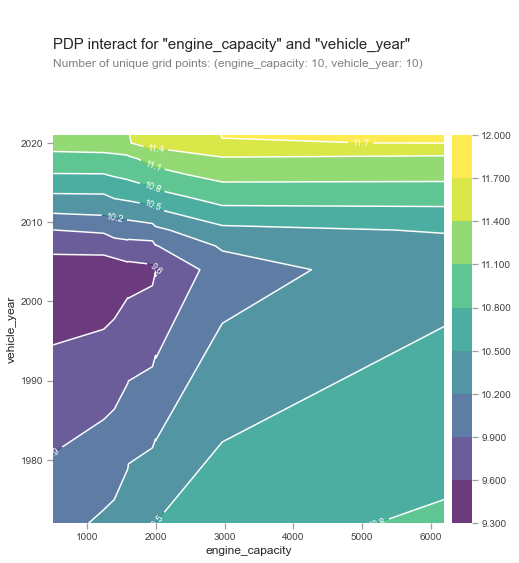

In [50]:
feats = ['engine_capacity', 'vehicle_year']
p = pdp.pdp_interact(model=m, dataset=x, model_features=x.columns, features=feats)
pdp.pdp_interact_plot(p, feats); plt.show()

# Challenges and further actions 

- The validation score of the current random forest model can be improved by finding the optimum set of hyperparameters using GridSearch or RandomSearch methods and considering the Out-Of-Bag (OOB) score as the metric.





- Random forest regression model learns and predicts the current data very well. However, the model poses a major challenge that it cannot extrapolate outside unseen data. As an example, if the new testing data contains the feature values which are outside the range of the current data, random forest will have trouble giving accurate predictions. To circumvent this issue, it might be beneficial to employ other regression algorithms (e.g. linear regression) which can develop a generalizing relationship function between features and target value. An important aspect to look at, while implementing these models is how to encode the categorical features. For example, the features `model` and `make` are nominal variables with cardinalities of 1165 and 108, respectively, which is very large. In such cases, encoding methods such as one-hot encoding will blow up the dataset due to creation of new sparse columns and lead to serious memory issues. In this respect, random forest model has very good advantage, since it can function well even if one simply turns the categories into numbers in the same column. However, to use other regression models, we can perhaps look at other ways of numerical encoding such as feature hashing or binary encoding, in order to minimize the creation of new columns, along with efficient regularization techniques to curb overfitting. One other way to reduce overfitting could be to group all the categorical feature (high cardinality ones such as `model`, `make`) elements with say less than 10 instances into a separate group `other`.




- The prediction accuracy can also be improved with the help of gradient boosting algorithm by using the models such as XGBoost or LightGBM and careful parameter tuning.

